### This method uses the basic convex hull method. It will potentially keep modelled points that are outside of the actual domain.

In [1]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shapely
from shapely.geometry import Polygon
import random
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
import shapely.geometry as geometry
import datetime

In [2]:
def make_the_plot(points):
    
    #print(points, '\n')
    hull = ConvexHull(points)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

    for ax in (ax1, ax2):
        ax.plot(points[:, 0], points[:, 1], '.', color='k')
        if ax == ax1:
            ax.set_title('Given points')
        else:
            ax.set_title('Convex hull')
            for simplex in hull.simplices:
                
                #print(points[simplex, 0], points[simplex, 1])
                ax.plot(points[simplex, 0], points[simplex, 1], 'c')
            
            #print('\n')
            #for pair in zip(points[hull.vertices, 0], points[hull.vertices, 1]):
            #    print(pair)
            ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
    plt.show()

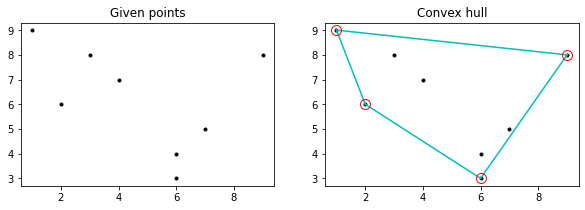

In [3]:
#sample_points = np.random.randint(0, 10, size=(15, 2))  # Random points in 2-D

x = [1, 6, 4, 9, 6, 7, 2, 3]
y = [9, 4, 7, 8, 3, 5, 6, 8]

points = np.stack((x, y)).transpose()
make_the_plot(points)

### This method uses concave hull to generate a tighter boundary, but has the disadvantage of potentially needing to customize the alpha value (currently set to 0.4)

In [4]:
# from: https://github.com/dwyerk/boundaries

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points.geoms) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points.geoms])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return unary_union(triangles), edge_points


# from: https://gist.github.com/dwyerk/10561690. This version of the function is supposed to be faster?
def vectorized_alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points.geoms) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    coords = np.array([point.coords[0] for point in points.geoms])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    #return cascaded_union(triangles), edge_points
    return unary_union(triangles), edge_points

def timed_function(func):
    time1 = datetime.datetime.now()
    concave_hull, edge_points = func
    time2 = datetime.datetime.now()
    #print('function took', (time2 - time1).seconds, 'seconds to run')
    elapsed_time = (time2 - time1).microseconds
    return concave_hull, edge_points, elapsed_time

def find_boundary(points, x, y, method=None, alpha=0.2):

    #concave_hull, edge_points = alpha_shape(points, alpha=0.2)
    if method == 'vectorized':
        concave_hull, edge_points, elapsed_time = timed_function(vectorized_alpha_shape(points, alpha=alpha))
        print('\n\nUsing vectorized_alpha_shape: function took ' + str(elapsed_time) + ' microseconds to run')
    else:
        concave_hull, edge_points, elapsed_time = timed_function(alpha_shape(points, alpha=alpha))
        print('\n\nUsing alpha_shape: function took ' + str(elapsed_time) + ' microseconds to run')
    
    plt.plot(x, y, '.')
    plt.title(method)
    try:
        plt.plot(*concave_hull.exterior.xy)
        plt.show()
    except:
        print(concave_hull)



Using alpha_shape: function took 0 microseconds to run




Using vectorized_alpha_shape: function took 0 microseconds to run


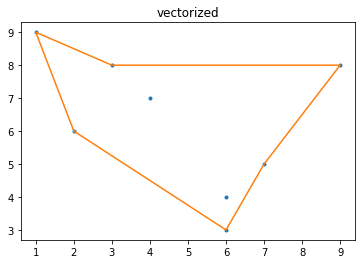

In [5]:
x = [1, 6, 4, 9, 6, 7, 2, 3]
y = [9, 4, 7, 8, 3, 5, 6, 8]
points = geometry.MultiPoint(list(zip(x, y)))

find_boundary(points, x, y)
find_boundary(points, x, y, method='vectorized')



Using alpha_shape: function took 0 microseconds to run




Using vectorized_alpha_shape: function took 0 microseconds to run


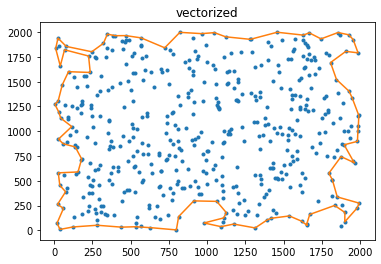

In [6]:
random_x = random.sample(range(1, 2000), 500)
random_y = random.sample(range(1, 2000), 500)
sample_points = geometry.MultiPoint(list(zip(random_x, random_y)))

find_boundary(sample_points, random_x, random_y, alpha=0.01)
find_boundary(sample_points, random_x, random_y, method='vectorized', alpha=0.01)

In [7]:
random_x = random.sample(range(1, 2000), 500)
random_y = random.sample(range(1, 2000), 500)
sample_points = geometry.MultiPoint(list(zip(random_x, random_y)))

find_boundary(sample_points, random_x, random_y, alpha=0.00010)
find_boundary(sample_points, random_x, random_y, method='vectorized', alpha=.00010)



Using alpha_shape: function took 0 microseconds to run




Using vectorized_alpha_shape: function took 0 microseconds to run


In [55]:
data = np.linspace(0, 1, 100000)
print(data.shape)
decimated = data[:100:]
print(decimated.shape)

(100000,)
(100,)
